# 1. Environment

In [1]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from PIL import Image
import random
import seaborn as sns
from tqdm import tqdm
import torch
import torchvision

In [2]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 2. Load

In [5]:
input_path = Path("../input")
train_imgs_path = input_path / "train_images"
print("Train Images:%d" % len(list(train_imgs_path.glob("*jpg"))))

Train Images:3881


In [6]:
train = pd.read_csv(input_path / "train.csv")
uc_trans = pd.read_csv(input_path / "unicode_translation.csv")

# 3. Feature Engineering

## Check Training Images

In [7]:
train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 2 columns):
image_id    3881 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 60.8+ KB


Some `labels` seem to contain `NaN` in `train`.  
We check showing top-6 images containing `NaN` at `labels`.

In [9]:
train_nan_labels = train[train["labels"].isnull()]
train_nan_labels.head(6)

,image_id,labels
66,100241706_00038_2,NaN
67,100241706_00039_1,NaN
68,100241706_00039_2,NaN
69,100241706_00040_1,NaN
73,100249371_00003_2,NaN
74,100249371_00004_1,NaN


In [10]:
train_nan_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 66 to 3880
Data columns (total 2 columns):
image_id    276 non-null object
labels      0 non-null object
dtypes: object(2)
memory usage: 6.5+ KB


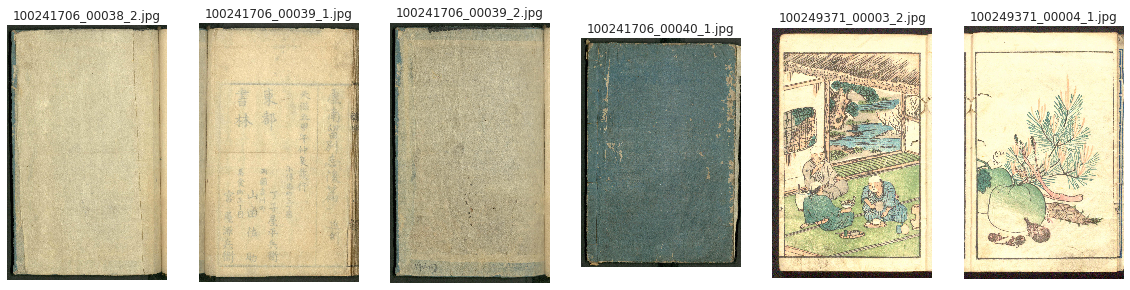

In [11]:
fig = plt.figure(figsize=(20, 80))
for i in range(6):
    image_id = train_nan_labels["image_id"].iloc[i]
    file_name = image_id + ".jpg"
    train_img_path = train_imgs_path / file_name
    train_img = np.asarray(Image.open(train_img_path))
    fig.add_subplot(1, 6, i+1, title=file_name)
    plt.axis("off")
    plt.imshow(train_img)
plt.show()

It seem to contain no characters in `NaN` label's images.  
Therefore, we can delete them all and reset the index.

In [12]:
train = train.dropna()
train = train.reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 2 columns):
image_id    3605 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 56.5+ KB


We use **3605** training images.

## Create Characters Data

In [13]:
train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


From [Data Description](https://www.kaggle.com/c/kuzushiji-recognition/data),

> The string should be read as space separated series of values where `Unicode character`, `X`, `Y`, `Width`, and `Height` are repeated as many times as necessary.

We create a dictionary `train_chars` where the key is `image_id` and the value is a dictionary containing `Unicode character`, `X`, `Y`, `Width` and `Height`.

In [14]:
train_chars = {}
train_chars_num = 0
for i in tqdm(range(train.shape[0])):
    image_id = train.iloc[i]["image_id"]
    labels = train.iloc[i]["labels"].split(" ")
    values = {"Unicode" : [],
              "X" : [],
              "Y" : [],
              "Width" : [],
              "Height" : []}
    for j in range(0, len(labels), 5):
        uc = labels[j]
        x = int(labels[j+1])
        y = int(labels[j+2])
        w = int(labels[j+3])
        h = int(labels[j+4])
        values["Unicode"].append(uc)
        values["X"].append(x)
        values["Y"].append(y)
        values["Width"].append(w)
        values["Height"].append(h)
        train_chars_num += 1
    train_chars[image_id] = values
train_chars_num

100%|██████████| 3605/3605 [00:01<00:00, 2201.11it/s]


683464

We get **683464** character images(seems to be too large).  
We check showing top-6 characters at 1st `image_id` and its images.

Unicode:U+306F,X:1231,Y:3465,Width:133,Height:53
Unicode:U+304C,X:275,Y:1652,Width:84,Height:69
Unicode:U+3044,X:1495,Y:1218,Width:143,Height:69
Unicode:U+3051,X:220,Y:3331,Width:53,Height:91
Unicode:U+306B,X:911,Y:1452,Width:61,Height:92
Unicode:U+306B,X:927,Y:3445,Width:71,Height:92


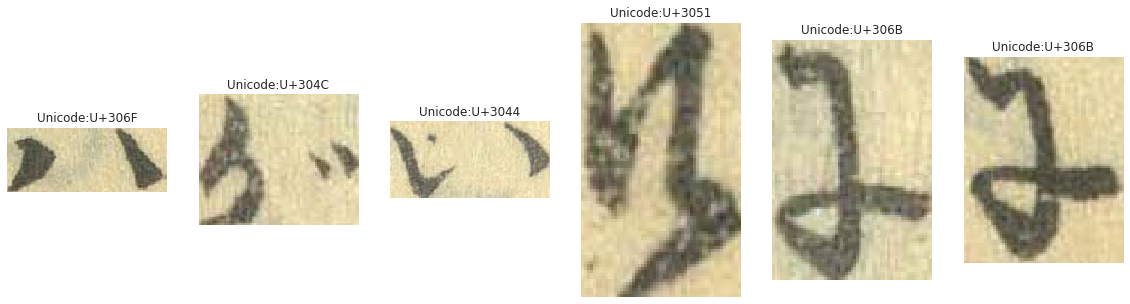

In [15]:
fig = plt.figure(figsize=(20, 80))
image_id_1st = train.iloc[0]["image_id"]
img_1st = Image.open(train_imgs_path/(image_id_1st+".jpg"))
for i in range(6):
    uc = train_chars[image_id_1st]["Unicode"][i]
    x = train_chars[image_id_1st]["X"][i]
    y = train_chars[image_id_1st]["Y"][i]
    w = train_chars[image_id_1st]["Width"][i]
    h = train_chars[image_id_1st]["Height"][i]
    img = img_1st.crop((x, y, x+w, y+h))
    args = (uc, x, y, w, h)
    print("Unicode:%s,X:%d,Y:%d,Width:%d,Height:%d" % args)
    fig.add_subplot(1, 6, i+1, title="Unicode:%s" % uc)
    plt.axis("off")
    plt.imshow(np.asarray(img))
plt.show()

Each image has diffrent width and height.  
We have to consider resizing images while the training.

## Decide Resizing scale

We check histgrams of width and height.

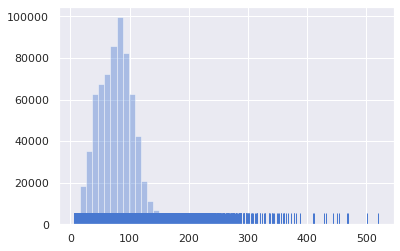

In [16]:
plot_data = []
for train_chars_value in train_chars.values():
    plot_data.extend(train_chars_value["Width"])
sns.distplot(plot_data, kde=False, rug=True)

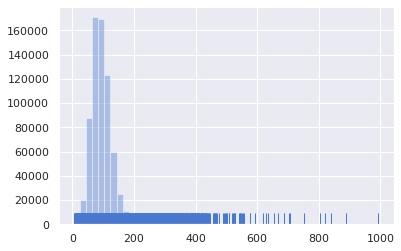

In [17]:
plot_data = []
for train_chars_value in train_chars.values():
    plot_data.extend(train_chars_value["Height"])
sns.distplot(plot_data, kde=False, rug=True)

Some width or height are too large.  
For the time being, we decide the resizing scale by fixed values(=48).

In [18]:
w_resize = 48
h_resize = 48

## Check Unicodes

In [19]:
uc_trans.head()

,Unicode,char
0,U+0031,1
1,U+0032,2
2,U+0034,4
3,U+0036,6
4,U+0039,9


In [20]:
uc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 2 columns):
Unicode    4787 non-null object
char       4787 non-null object
dtypes: object(2)
memory usage: 74.9+ KB


There are 4787 classes of all unicode characters.  
However, some characters might be useless in training images.  
We check useless unicodes which are in `uc_trans["Unicode"]` and are not in all unicodes of `train_chars`.

In [21]:
train_chars_ucs = set()
for train_chars_value in train_chars.values():
    train_chars_ucs |= set(train_chars_value["Unicode"])
uc_trans[~uc_trans["Unicode"].isin(train_chars_ucs)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 4770
Data columns (total 2 columns):
Unicode    575 non-null object
char       575 non-null object
dtypes: object(2)
memory usage: 13.5+ KB


There seems to be 575 useless unicodes in training images.  
Finally, we shrink `uc_trans` from 4787 classes to **4212**(=4787-575).

In [22]:
uc_trans = uc_trans[uc_trans["Unicode"].isin(train_chars_ucs)]
uc_trans.to_csv("../cache/my_unicode_translation.csv")
uc_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4212 entries, 5 to 4786
Data columns (total 2 columns):
Unicode    4212 non-null object
char       4212 non-null object
dtypes: object(2)
memory usage: 98.7+ KB


We create a list of unicode `uc_list` whose index is used for training and test labels.

In [23]:
uc_list = uc_trans["Unicode"].values.tolist()
uc_list.index("U+306F")

84

# 4. Create Pytorch Dataset

We define `KuzushijiCharDataset` class extended from `torch.utils.data.Dataset`.  
As it costs little time to get i-th training data, it creates as follows.
1. Open PIL Image each `image_id`
2. Crop as Character's PIL Image
3. Resize Character's PIL Image
4. Gray-Scale Character's PIL Image where the channel is 1
5. Convert from Character's PIL Image to Tensor

In [24]:
class KuzushijiCharDataset(torch.utils.data.Dataset):
    def __init__(self,
                 chars: dict,
                 uc_list: list,
                 train_imgs_path: Path,
                 scale_resize: tuple):
        self._x_in_list = []
        self._y_list = []
        for image_id, values in tqdm(chars.items()):
            # Open PIL Image each image_id
            img = Image.open(train_imgs_path/(image_id+".jpg"))
            values_zip = zip(values["Unicode"],
                             values["X"],
                             values["Y"],
                             values["Width"],
                             values["Height"])
            for uc, x, y, w, h in values_zip:
                # Crop as Character's PIL Image
                img_char = img.crop((x, y, x+w, y+h))
                # Resize Character's PIL Image
                img_char = img_char.resize(scale_resize)
                # Gray-Scale Character's PIL Image where the channel is 1
                img_char = img_char.convert('L')
                # Convert from Character's PIL Image to Tensor
                img_char = torchvision.transforms.functional.to_tensor(img_char)
                # Add Training Data
                self._x_in_list.append(img_char)
                # Add Training Label
                uc_idx = uc_list.index(uc)
                self._y_list.append(uc_idx)

    def __len__(self):
        return len(self._y_list)
    
    def __getitem__(self, idx: int):
        x_in = self._x_in_list[idx]
        y = self._y_list[idx]
        return x_in, y

In [25]:
dataset = KuzushijiCharDataset(train_chars,
                               uc_list,
                               train_imgs_path,
                               (w_resize, h_resize))
print(len(dataset))

100%|██████████| 3605/3605 [04:03<00:00, 14.79it/s]

683464


We split a dataset into training dataset(90%) and validation one(10%).

In [26]:
train_size = int(len(dataset) * 0.9)
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset,
                                                             [train_size, valid_size])
args = (len(dataset), len(train_dataset), len(valid_dataset))
print("Total:%d,Training:%d,Validation:%d" % args)

Total:683464,Training:615117,Validation:68347


# 5. Demonstration for Classifying Characters

## Create Network

We define an original model where
* We define 1 input channel at the 1st layer `conv1` because of gray-scaled.
* We define 4212(=Character Classes) input output features at the affine layer `fc`.

In [27]:
class DemoModel(torch.nn.Module):
    def __init__(self):
        super(DemoModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=16,
                                     kernel_size=7).to(device)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16,
                                     out_channels=128,
                                     kernel_size=6).to(device)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc = torch.nn.Linear(in_features=128*8*8,
                                  out_features=4212,
                                  bias=True).to(device)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1).to(device)

    def forward(self, x):
        out = self.conv1(x) # (batch, 1, 48, 48) -> (batch, 16, 42, 42)
        out = self.relu1(out)
        out = self.maxpool1(out) # (batch, 16, 42, 42) -> (batch, 16, 21, 21)
        out = self.conv2(out) # (batch, 16, 21, 21) -> (batch, 128, 16, 16)
        out = self.relu2(out)
        out = self.maxpool2(out) # (batch, 128, 16, 16) -> (batch, 128, 8, 8)
        out = out.view(out.size(0), -1) # (batch, 128, 8, 8) -> (batch, 8192)
        out = self.fc(out) # (batch, 8192) -> (batch, 4212)
        out = self.log_softmax(out)
        return out

In [28]:
network = DemoModel()
network

DemoModel(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 128, kernel_size=(6, 6), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8192, out_features=4212, bias=True)
  (log_softmax): LogSoftmax()
)

## Define Training Parameters

In [29]:
max_epochs = 1
batch_size = 1024
lr = 0.005
optimizer = torch.optim.Adam(network.parameters())
criterion = torch.nn.NLLLoss()
train_dataLoader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=6)
valid_dataLoader = torch.utils.data.DataLoader(valid_dataset,
                                               num_workers=6)

## Train

In [30]:
%%time
result = {"Epoch" : [],
          "Type" : [],
          "Average Loss" : [],
          "Accuracy" : []}

for epoch in range(1, max_epochs+1):
    # Training
    sum_loss = 0.0
    correct = 0
    for x_in, y in tqdm(train_dataLoader):
        network.zero_grad()
        x_out = network(x_in.to(device))
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() * x_in.shape[0]
        correct += int(torch.sum(torch.argmax(x_out, 1) == y.to(device)))
    ave_loss = sum_loss / len(train_dataset)
    accuracy = 100.0 * correct / len(train_dataset)
    result["Epoch"].append(epoch)
    result["Type"].append("Training")
    result["Average Loss"].append(ave_loss)
    result["Accuracy"].append(accuracy)
    args = (datetime.now().isoformat(), epoch, max_epochs, ave_loss, accuracy)
    print("Type:Training,Time:%s,Epoch:%d/%d,Average Loss:%.3f,Accuracy:%.3f%%" % args)

    # Validation
    sum_loss = 0.0
    correct = 0
    for x_in, y in tqdm(valid_dataLoader):
        x_out = network(x_in.to(device))
        loss = criterion(x_out, y.to(device))
        sum_loss += loss.item() * x_in.shape[0]
        correct += int(torch.sum(torch.argmax(x_out, 1) == y.to(device)))
    ave_loss = sum_loss / len(valid_dataset)
    accuracy = 100.0 * correct / len(valid_dataset)
    result["Epoch"].append(epoch)
    result["Type"].append("Validation")
    result["Average Loss"].append(ave_loss)
    result["Accuracy"].append(accuracy)
    args = (datetime.now().isoformat(), epoch, max_epochs, ave_loss, accuracy)
    print("Type:Validation,Time:%s,Epoch:%d/%d,Average Loss:%.3f,Accuracy:%.3f%%" % args)

torch.save(network.state_dict(), '../cache/classify_model.pth')

  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:37:21.548701,Epoch:1/10,Average Loss:1.843,Accuracy:66.812%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T00:39:38.630577,Epoch:1/10,Average Loss:0.883,Accuracy:82.312%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:41:03.832091,Epoch:2/10,Average Loss:0.536,Accuracy:87.710%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T00:43:19.687526,Epoch:2/10,Average Loss:0.675,Accuracy:86.608%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:44:44.756938,Epoch:3/10,Average Loss:0.297,Accuracy:92.642%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T00:47:02.004895,Epoch:3/10,Average Loss:0.650,Accuracy:87.433%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:48:26.996235,Epoch:4/10,Average Loss:0.204,Accuracy:94.746%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T00:50:42.916969,Epoch:4/10,Average Loss:0.645,Accuracy:88.251%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:52:07.903204,Epoch:5/10,Average Loss:0.156,Accuracy:95.863%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T00:54:24.470555,Epoch:5/10,Average Loss:0.677,Accuracy:88.534%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:55:49.491068,Epoch:6/10,Average Loss:0.127,Accuracy:96.537%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T00:58:05.485576,Epoch:6/10,Average Loss:0.694,Accuracy:88.747%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T00:59:30.461367,Epoch:7/10,Average Loss:0.107,Accuracy:97.000%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T01:01:47.076617,Epoch:7/10,Average Loss:0.702,Accuracy:88.781%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T01:03:12.103529,Epoch:8/10,Average Loss:0.093,Accuracy:97.356%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T01:05:28.634014,Epoch:8/10,Average Loss:0.739,Accuracy:88.845%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T01:06:53.631516,Epoch:9/10,Average Loss:0.082,Accuracy:97.612%


  0%|          | 0/601 [00:00<?, ?it/s]

Type:Validation,Time:2019-10-04T01:09:10.259511,Epoch:9/10,Average Loss:0.760,Accuracy:88.738%


  0%|          | 0/68347 [00:00<?, ?it/s]

Type:Training,Time:2019-10-04T01:10:35.293765,Epoch:10/10,Average Loss:0.074,Accuracy:97.824%


100%|██████████| 68347/68347 [02:16<00:00, 499.21it/s]

Type:Validation,Time:2019-10-04T01:12:52.204267,Epoch:10/10,Average Loss:0.817,Accuracy:88.599%
CPU times: user 29min 5s, sys: 7min 21s, total: 36min 27s
Wall time: 36min 55s


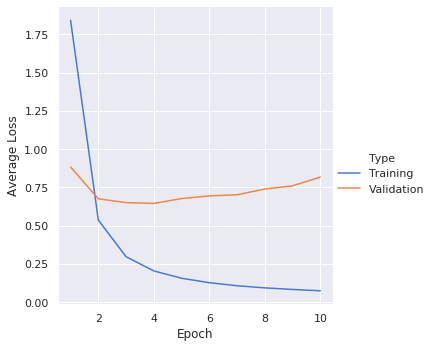

In [31]:
sns.relplot(x="Epoch",
            y="Average Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result))

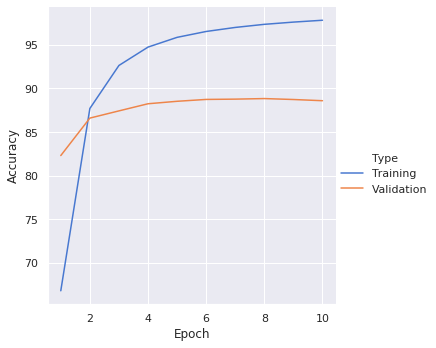

In [32]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result))

In [ ]:
# TODO: 封装分类字符的模型